In [1]:
!pip install -q transformers
!pip install -q datasets
!pip install -q torch
!pip install -q evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==

In [2]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AlbertTokenizer, AlbertForSequenceClassification, AlbertForQuestionAnswering
from datasets import load_dataset
from datasets import Dataset
from transformers import TrainingArguments, Trainer
import torch
from sklearn.model_selection import StratifiedKFold
import os
import evaluate
from sklearn.utils.class_weight import compute_class_weight
from transformers.utils import logging

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# load and split data into test set
df = pd.read_csv('./drive/MyDrive/w266/project/labeled_data.csv')
train_val_df, test_df = train_test_split(df, test_size=0.15, random_state=42, stratify=df["label"])

train_val_df.to_json("train.json", orient="records", lines=True)
test_df.to_json("test.json", orient="records", lines=True)

print(f"Training set: {len(train_val_df)} samples")
print(f"Test set: {len(test_df)} samples")

Training set: 389 samples
Test set: 69 samples


In [8]:
# load ALBERT tokenizer and qa model trained on CoQA
tokenizer = AlbertTokenizer.from_pretrained("./drive/MyDrive/w266/project/model_checkpoints/albert_coqa_qnli")

model = AlbertForSequenceClassification.from_pretrained("./drive/MyDrive/w266/project/model_checkpoints/albert_coqa_qnli")



In [9]:
# set up for training
def preprocess_function(examples):
    return tokenizer(examples["question"], examples["response"], truncation=True, padding="max_length", max_length=512)

labels = train_val_df["label"].tolist()

num_folds = 4
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

In [10]:
# weight classes due to imbalanced data set
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

class_weights_tensor = torch.tensor(list(class_weights.values())).float().to(device)

print(class_weights)


{0: np.float64(0.538781163434903), 1: np.float64(6.946428571428571)}


In [11]:
# add evaluation measures
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    return {
        "accuracy": accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"],
        "precision": precision_metric.compute(predictions=predictions, references=labels, average="binary")["precision"],
        "recall": recall_metric.compute(predictions=predictions, references=labels, average="binary")["recall"],
        "f1": f1_metric.compute(predictions=predictions, references=labels, average="binary")["f1"]
    }

In [12]:
# create instance of trainer class for weighted training
class WeightedTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
          labels = inputs.get("labels")
          outputs = model(**inputs)
          logits = outputs.logits

          loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
          loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

          return (loss, outputs) if return_outputs else loss

In [13]:
# loop through folds for cross validation
for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_df, labels)):
    print(f"Training on Fold {fold+1}/{num_folds}")

    train_df = train_val_df.iloc[train_idx]
    val_df = train_val_df.iloc[val_idx]

    train_dataset = Dataset.from_pandas(train_df).map(preprocess_function, batched=True)
    val_dataset = Dataset.from_pandas(val_df).map(preprocess_function, batched=True)

    model = AlbertForSequenceClassification.from_pretrained("./drive/MyDrive/w266/project/model_checkpoints/albert_coqa_qnli")


    training_args = TrainingArguments(
        output_dir=f"./results_fold_{fold}",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_dir=f"./logs_fold_{fold}",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=4,
        weight_decay=0.01,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        report_to="none"
    )

    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    logging.set_verbosity_error()

    trainer.train()

    print(f"Evaluation for Fold {fold+1}")
    trainer.evaluate()

Training on Fold 1/4


Map:   0%|          | 0/291 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Map:   0%|          | 0/98 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.704472,0.928571,0.000000,0.000000,0.000000
2,No log,0.740328,0.928571,0.500000,0.142857,0.222222
3,No log,0.712277,0.918367,0.400000,0.285714,0.333333
4,No log,0.760041,0.918367,0.400000,0.285714,0.333333


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluation for Fold 1


Training on Fold 2/4


Map:   0%|          | 0/292 [00:00<?, ? examples/s]

Map:   0%|          | 0/97 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-13-9a902c11211b>:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.6534909009933472, 'eval_accuracy': 0.9278350515463918, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.0454, 'eval_samples_per_second': 31.851, 'eval_steps_per_second': 2.299, 'epoch': 1.0}
{'eval_loss': 0.6840008497238159, 'eval_accuracy': 0.6494845360824743, 'eval_precision': 0.09090909090909091, 'eval_recall': 0.42857142857142855, 'eval_f1': 0.15, 'eval_runtime': 3.0941, 'eval_samples_per_second': 31.35, 'eval_steps_per_second': 2.262, 'epoch': 2.0}
{'eval_loss': 0.7676283717155457, 'eval_accuracy': 0.8247422680412371, 'eval_precision': 0.1875, 'eval_recall': 0.42857142857142855, 'eval_f1': 0.2608695652173913, 'eval_runtime': 3.0355, 'eval_samples_per_second': 31.955, 'eval_steps_per_second': 2.306, 'epoch': 3.0}
{'eval_loss': 0.7910194993019104, 'eval_accuracy': 0.845360824742268, 'eval_precision': 0.16666666666666666, 'eval_recall': 0.2857142857142857, 'eval_f1': 0.21052631578947367, 'eval_runtime': 3.109, 'eval_samples_per_second': 31.

Map:   0%|          | 0/292 [00:00<?, ? examples/s]

Map:   0%|          | 0/97 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-13-9a902c11211b>:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


{'eval_loss': 0.9383258819580078, 'eval_accuracy': 0.8762886597938144, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.04, 'eval_samples_per_second': 31.908, 'eval_steps_per_second': 2.303, 'epoch': 1.0}
{'eval_loss': 0.8583130240440369, 'eval_accuracy': 0.7216494845360825, 'eval_precision': 0.08333333333333333, 'eval_recall': 0.2857142857142857, 'eval_f1': 0.12903225806451613, 'eval_runtime': 3.0512, 'eval_samples_per_second': 31.79, 'eval_steps_per_second': 2.294, 'epoch': 2.0}
{'eval_loss': 0.9513395428657532, 'eval_accuracy': 0.7731958762886598, 'eval_precision': 0.058823529411764705, 'eval_recall': 0.14285714285714285, 'eval_f1': 0.08333333333333333, 'eval_runtime': 3.0987, 'eval_samples_per_second': 31.304, 'eval_steps_per_second': 2.259, 'epoch': 3.0}
{'eval_loss': 1.0464786291122437, 'eval_accuracy': 0.8144329896907216, 'eval_precision': 0.07692307692307693, 'eval_recall': 0.14285714285714285, 'eval_f1': 0.1, 'eval_runtime': 3.0486, 'eval_samples_pe

Map:   0%|          | 0/292 [00:00<?, ? examples/s]

Map:   0%|          | 0/97 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-13-9a902c11211b>:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


{'eval_loss': 0.6776652932167053, 'eval_accuracy': 0.9072164948453608, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.1012, 'eval_samples_per_second': 31.278, 'eval_steps_per_second': 2.257, 'epoch': 1.0}
{'eval_loss': 0.6930462718009949, 'eval_accuracy': 0.865979381443299, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.0151, 'eval_samples_per_second': 32.171, 'eval_steps_per_second': 2.322, 'epoch': 2.0}
{'eval_loss': 0.689497172832489, 'eval_accuracy': 0.9072164948453608, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.019, 'eval_samples_per_second': 32.13, 'eval_steps_per_second': 2.319, 'epoch': 3.0}
{'eval_loss': 0.6819177269935608, 'eval_accuracy': 0.9175257731958762, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 3.1023, 'eval_samples_per_second': 31.267, 'eval_steps_per_second': 2.256, 'epoch': 4.0}
{'train_runtime': 120.5215, 'train_samples_per_second': 9.691, '

In [14]:
# check misclassified examples
train_preds_output = trainer.predict(train_dataset)
train_logits = train_preds_output.predictions
train_preds = np.argmax(train_logits, axis=-1)
train_labels = train_preds_output.label_ids

val_preds_output = trainer.predict(val_dataset)
val_logits = val_preds_output.predictions
val_preds = np.argmax(val_logits, axis=-1)
val_labels = val_preds_output.label_ids

train_df = pd.DataFrame({"Actual": train_labels, "Predicted": train_preds})
val_df = pd.DataFrame({"Actual": val_labels, "Predicted": val_preds})

train_misclassified = train_df[train_df["Actual"] != train_df["Predicted"]]
print(f"Training Misclassified Examples:\n{train_misclassified}")

val_misclassified = val_df[val_df["Actual"] != val_df["Predicted"]]
print(f"\nValidation Misclassified Examples:\n{val_misclassified}")



Training Misclassified Examples:
     Actual  Predicted
41        1          0
42        0          1
49        0          1
64        0          1
77        0          1
88        1          0
98        0          1
102       0          1
113       1          0
117       1          0
127       1          0
131       1          0
134       0          1
139       1          0
153       1          0
154       0          1
158       0          1
164       1          0
174       1          0
187       0          1
205       0          1
212       1          0
218       0          1
227       1          0
231       1          0
239       1          0
244       1          0
245       1          0
252       0          1
274       0          1
283       1          0

Validation Misclassified Examples:
    Actual  Predicted
1        1          0
10       1          0
23       1          0
30       1          0
36       1          0
38       1          0
39       0          1
51       0         

In [15]:
model.save_pretrained('./drive/MyDrive/w266/project/model_checkpoints/A_C_Q', from_pt=True)
tokenizer.save_pretrained('./drive/MyDrive/w266/project/model_checkpoints/A_C_Q', from_pt=True)


('./drive/MyDrive/w266/project/model_checkpoints/A_C_Q/tokenizer_config.json',
 './drive/MyDrive/w266/project/model_checkpoints/A_C_Q/special_tokens_map.json',
 './drive/MyDrive/w266/project/model_checkpoints/A_C_Q/spiece.model',
 './drive/MyDrive/w266/project/model_checkpoints/A_C_Q/added_tokens.json')

In [16]:
train_dataset_final = Dataset.from_pandas(train_val_df).map(preprocess_function, batched=True)

model = AlbertForSequenceClassification.from_pretrained("./drive/MyDrive/w266/project/model_checkpoints/albert_coqa_qnli")


training_args = TrainingArguments(
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    num_train_epochs=8,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    report_to="none"
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_final,
    eval_dataset=train_dataset_final,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

logging.set_verbosity_error()

trainer.train()

Map:   0%|          | 0/389 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-16-b88806a10d37>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


{'eval_loss': 0.5981407165527344, 'eval_accuracy': 0.8457583547557841, 'eval_precision': 0.16666666666666666, 'eval_recall': 0.2857142857142857, 'eval_f1': 0.21052631578947367, 'eval_runtime': 11.8924, 'eval_samples_per_second': 32.71, 'eval_steps_per_second': 4.12, 'epoch': 1.0}
{'eval_loss': 0.5740251541137695, 'eval_accuracy': 0.7069408740359897, 'eval_precision': 0.15873015873015872, 'eval_recall': 0.7142857142857143, 'eval_f1': 0.2597402597402597, 'eval_runtime': 11.797, 'eval_samples_per_second': 32.975, 'eval_steps_per_second': 4.154, 'epoch': 2.0}
{'eval_loss': 0.49234142899513245, 'eval_accuracy': 0.9023136246786633, 'eval_precision': 0.3684210526315789, 'eval_recall': 0.5, 'eval_f1': 0.42424242424242425, 'eval_runtime': 11.8811, 'eval_samples_per_second': 32.741, 'eval_steps_per_second': 4.124, 'epoch': 3.0}
{'eval_loss': 0.4028821587562561, 'eval_accuracy': 0.9125964010282777, 'eval_precision': 0.40625, 'eval_recall': 0.4642857142857143, 'eval_f1': 0.43333333333333335, 'eval

TrainOutput(global_step=200, training_loss=0.5109486389160156, metrics={'train_runtime': 383.9459, 'train_samples_per_second': 8.105, 'train_steps_per_second': 0.521, 'train_loss': 0.5109486389160156, 'epoch': 8.0})

In [17]:
model.save_pretrained('./drive/MyDrive/w266/project/model_checkpoints/A_C_Q2', from_pt=True)
tokenizer.save_pretrained('./drive/MyDrive/w266/project/model_checkpoints/A_C_Q2', from_pt=True)


('./drive/MyDrive/w266/project/model_checkpoints/A_C_Q2/tokenizer_config.json',
 './drive/MyDrive/w266/project/model_checkpoints/A_C_Q2/special_tokens_map.json',
 './drive/MyDrive/w266/project/model_checkpoints/A_C_Q2/spiece.model',
 './drive/MyDrive/w266/project/model_checkpoints/A_C_Q2/added_tokens.json')

In [18]:
# check final misclassifications
all_preds_output = trainer.predict(train_dataset_final)
all_logits = all_preds_output.predictions
all_preds = np.argmax(all_logits, axis=-1)
all_labels = all_preds_output.label_ids


all_comparison = pd.DataFrame({"Actual": all_labels, "Predicted": all_preds})

all_misclassified = all_comparison[all_comparison["Actual"] != all_comparison["Predicted"]]

print(all_misclassified)

     Actual  Predicted
13        1          0
46        1          0
53        1          0
85        1          0
102       1          0
215       0          1
221       1          0
293       0          1
309       1          0
335       0          1
384       0          1


In [19]:
saved_model = "./drive/MyDrive/w266/project/model_checkpoints/A_C_Q2"
saved_tokenizer = "./drive/MyDrive/w266/project/model_checkpoints/A_C_Q2"

tokenizer = AlbertTokenizer.from_pretrained(saved_tokenizer)
model = AlbertForSequenceClassification.from_pretrained(saved_model, num_labels=2)


In [20]:
test_dataset = Dataset.from_pandas(test_df)

In [21]:
def predict(example):
    encoding = tokenizer(example['question'], example['response'],
                         truncation=True, padding="max_length", max_length=512, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=-1).item()
    return predicted_class

test_predictions = [predict(example) for example in test_dataset]

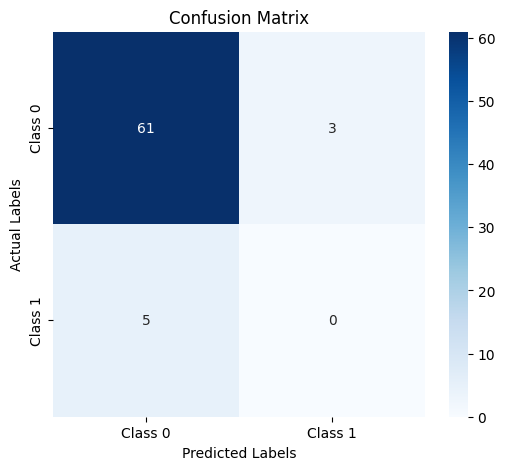

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = test_df['label'].to_list()

cm = confusion_matrix(labels, test_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()


In [38]:
# check examples labeled as 1
test_df[test_df['label']==1]

,Unnamed: 0,interviewer,question,interviewee,response,follow-up,label_claude,label_openai,label_google,label
59,59,Juan Manuel Benítez,Do you think there’s a disconnect? You ran uno...,Jessica Ramos,"Oh, the Trump-Ramos vote was strong [in my dis...",So is there a disconnect between your policies...,1,1,1,1
74,74,Nicole Gelinas,So you don’t see an economic development argum...,Jessica Ramos,Of course is does —,So you don’t buy into that?,1,1,1,1
180,180,Ben Smith,"And actually just to go back, is that what you...",Zohran Mamdani,"When we launched the campaign, a leader in TWU...",So you are saying that the reason there’s viol...,1,0,1,1
315,315,Josh Greenman,How do you do that with so many historic distr...,Zellnor Myrie,"Well, I think the tides are beginning to chang...","But just to be clear, landmarking is the perma...",1,1,1,1
1,1,Josh Greenman,Which crimes have gone up the most since the p...,Brad Lander,"Yeah. I mean, obviously, there was a huge rise...",Do you know which violent crimes have seen the...,1,1,1,1


In [57]:
# check examples predicted as 1
mask = np.array(test_predictions)
test_df.loc[mask==1]

,Unnamed: 0,interviewer,question,interviewee,response,follow-up,label_claude,label_openai,label_google,label
455,455,Josh Greenman,"But is a loud, raucous protest with posters th...",Whitney Tilson,“From the river to the sea.” “Globalize the In...,If you’re the mayor of New York City. What’s y...,0,0,0,0
108,108,Nicole Gelinas,Follow-up transit question: you said the bigge...,Jessica Ramos,The historical one.,But the MTA surveys and private polling would ...,0,0,0,0
360,360,Ben Max,You forgot something on Adams that you appreci...,Zellnor Myrie,The NYC Reads program.,"Senator, the front runner in this race is Andr...",0,0,0,0
